# **PROJET 1 : Segmentation du réseau vasculaire dans des images de rétine SLO**

#### Yannick Letord et Salimatou Traoré

# Table des Matières
1. [Les données](#les-données)
2. [Fonction d'évaluation](#fonction-dévaluation)

## A. Etapes de la segmentation
1. [I. Pre-Proceessing](#i-pre-proceessing)
   - [a. Filtres](#a-filtres)
   - [b. Contraste](#b-contraste)
   - [c. Suppression de l'arrière-plan](#c-suppression-de-larrière-plan)
   - [d. Débruitage](#d-débruitage)
   - [e. Binarisation](#e-binarisation)
2. [II. Segmentation](#ii-segmentation)
   - [Application d'un filtre linéaire et convolutions](#application-dun-filtre-linéaire-et-convolutions)
3. [III. Post-processing](#iii-post-processing)
   - [Application d'un masque et opérations morphologiques](#application-dun-masque-et-opérations-morphologiques)

## B. GridSearch
1. [GridSearch pour trouver les meilleurs approches pour chaques étapes de la segmentation](#gridsearch-pour-trouver-les-meilleurs-approches-pour-chaques-étapes-de-la-segmentation)
   - [a. GridSearch pour uniquement la première image](#a-gridsearch-pour-uniquement-la-première-image)
   - [b. GridSearch pour toutes les images](#b-gridsearch-pour-toutes-les-images)
   - [c. Fonction de segmentation](#c-fonction-de-segmentation)
     - [Création de la fonction de segmentation avec les méthodes trouvés à l'aide du GridSearch précédent](#création-de-la-fonction-de-segmentation-avec-les-méthodes-trouvés-à-laide-du-gridsearch-précédent)
2. [GridSearch pour trouver les meilleurs hyperparamètres pour chaques méthodes](#gridsearch-pour-trouver-les-meilleurs-hyperparamètres-pour-chaques-méthodes)
   - [a. GridSearch pour uniquement la première image](#a-gridsearch-pour-uniquement-la-première-image-1)
   - [b. GridSearch pour toutes les images](#b-gridsearch-pour-toutes-les-images-1)

## C. Résultats


## Importation des librairies

In [7]:
import numpy as np
import pandas as pd
from skimage.morphology import erosion, dilation, binary_erosion, opening, closing, white_tophat, reconstruction, black_tophat, skeletonize, convex_hull_image, thin
from skimage.morphology import square, diamond, octagon, rectangle, star, disk, diameter_opening
from skimage.filters.rank import entropy, enhance_contrast_percentile, enhance_contrast
from skimage.filters import threshold_otsu, gaussian, meijering, median, frangi, hessian, laplace
from skimage.exposure import equalize_adapthist
from skimage import io, exposure, filters, color, data, feature, img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2gray
from tqdm.notebook import tqdm
from PIL import Image
from scipy import ndimage as ndi
from skimage.util import img_as_ubyte, img_as_float
import math
from matplotlib import pyplot as plt
import cv2
import glob
from IPython.display import display, HTML
import random
from sklearn.model_selection import ParameterSampler
import os
import itertools
import json


/var/folders/cy/jxgrnlf57f78yz4v8gv0kn5h0000gn/T/ipykernel_46351/1251695996.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Les données

In [100]:
# Chemins vers les images d'origines
image_paths = ['images_IOSTAR/star01_OSC.jpg',
'images_IOSTAR/star02_OSC.jpg',
'images_IOSTAR/star03_OSN.jpg',
'images_IOSTAR/star08_OSN.jpg',
'images_IOSTAR/star21_OSC.jpg',
'images_IOSTAR/star26_ODC.jpg',
'images_IOSTAR/star28_ODN.jpg',
'images_IOSTAR/star32_ODC.jpg',
'images_IOSTAR/star37_ODN.jpg',
'images_IOSTAR/star48_OSN.jpg']

# Chemins vers les images vérité terrains
GT_paths = [
'images_IOSTAR/GT_01.png',
'images_IOSTAR/GT_02.png',
'images_IOSTAR/GT_03.png',
'images_IOSTAR/GT_08.png',
'images_IOSTAR/GT_21.png',
'images_IOSTAR/GT_26.png',
'images_IOSTAR/GT_28.png',
'images_IOSTAR/GT_32.png',
'images_IOSTAR/GT_37.png',
'images_IOSTAR/GT_48.png']

# la première image
img =  np.asarray(Image.open(image_paths[0])).astype(np.uint8)
img_GT =  np.asarray(Image.open(GT_paths[0])).astype(np.bool_)

In [97]:

# Supposons que vous ayez un dossier pour sauvegarder les images
images_folder = 'images_originales'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

# Création du tableau HTML
html_str = '<table><tr><th>Image Path</th><th>Original Image</th><th>Ground Truth</th></tr>'

for i, (img_path, gt_path) in enumerate(zip(image_paths, GT_paths), start=1):
    img = io.imread(img_path)
    gt = io.imread(gt_path)

    # Chemins pour enregistrer les images
    original_img_path = os.path.join(images_folder, f'original_{i}.png')
    gt_img_path = os.path.join(images_folder, f'gt_{i}.png')

    # Enregistrer les images
    plt.imsave(original_img_path, img, cmap='gray')
    plt.imsave(gt_img_path, gt, cmap='gray')

    # Ajouter une ligne au tableau HTML pour chaque image
    html_str += f'<tr><td>{img_path}</td>'
    html_str += f'<td><img src="{original_img_path}" width="100"></td>'
    html_str += f'<td><img src="{gt_img_path}" width="100"></td>'

html_str += '</table>'

# Afficher le tableau HTML dans le notebook
display(HTML(html_str))


Image Path,Original Image,Ground Truth
images_IOSTAR/star01_OSC.jpg,,
images_IOSTAR/star02_OSC.jpg,,
images_IOSTAR/star03_OSN.jpg,,
images_IOSTAR/star08_OSN.jpg,,
images_IOSTAR/star21_OSC.jpg,,
images_IOSTAR/star26_ODC.jpg,,
images_IOSTAR/star28_ODN.jpg,,
images_IOSTAR/star32_ODC.jpg,,
images_IOSTAR/star37_ODN.jpg,,
images_IOSTAR/star48_OSN.jpg,,


## Fonction d'évaluation

In [9]:
def evaluate(img_out, img_GT):
    GT_skel  = thin(img_GT, max_num_iter = 15) # On suppose que la demie epaisseur maximum 
    img_out_skel  = thin(img_out, max_num_iter = 15) # d'un vaisseau est de 15 pixels...
    TP = np.sum(img_out_skel & img_GT) # Vrais positifs
    FP = np.sum(img_out_skel & ~img_GT) # Faux positifs
    FN = np.sum(GT_skel & ~img_out) # Faux negatifs

    ACCU = TP / (TP + FP) # Precision
    RECALL = TP / (TP + FN) # Rappel
    F1_SCORE = (2*ACCU*RECALL)/(RECALL+ACCU)
    return ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel

# A. Etapes de la segmentation

## I. Pre-Proceessing

### a. Filtres

In [95]:
def apply_filter(image, filter_name):
    if filter_name == 'median':
        return median(image)
    elif filter_name == 'hessian':
        return hessian(image)
    elif filter_name == 'laplace':
        return laplace(image)
    elif filter_name == 'frangi':
        return frangi(image)
    else:
        raise ValueError(f"Unknown filter: {filter_name}")

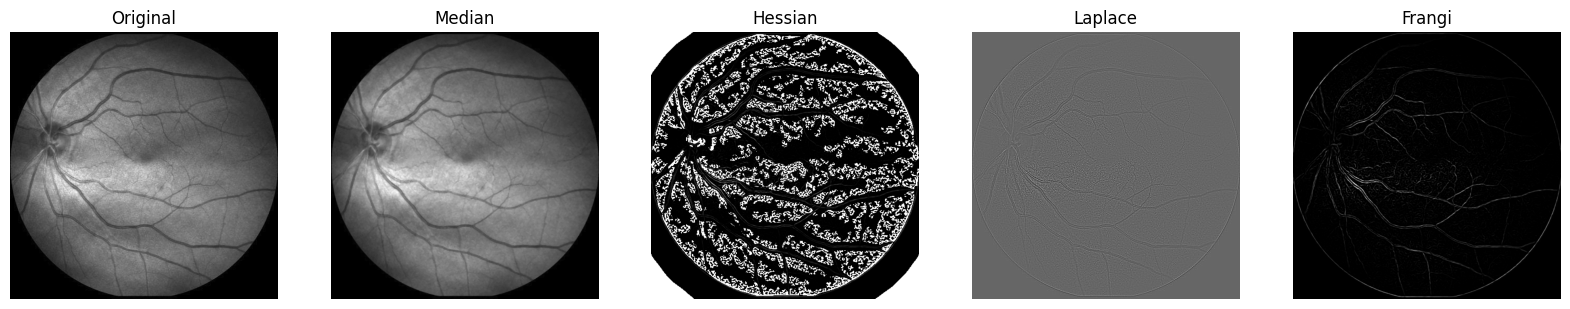

In [96]:
import matplotlib.pyplot as plt

# Supposons que `filtered_images` est un dictionnaire contenant les images filtrées
filtered_images = {
    'Original': img,
    'Median': apply_filter(img, 'median'),
    'Hessian': apply_filter(img, 'hessian'),
    'Laplace': apply_filter(img, 'laplace'),
    'Frangi': apply_filter(img, 'frangi')
}

fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Ajustez le nombre de subplots en fonction du nombre d'images

for ax, (title, image) in zip(axes, filtered_images.items()):
    ax.imshow(image, cmap='gray')
    ax.title.set_text(title)
    ax.axis('off')

plt.show()


### b. Contraste

In [98]:
def apply_contrast(image, method):
    if method == 'CLAHE':
        return equalize_adapthist(image, kernel_size=32)  # skimage's CLAHE
    
    elif method == 'Gamma':
        retina_corrected_gamma = np.power(image, 1.2)
        retina_corrected_gamma_normalized = (retina_corrected_gamma-np.min(retina_corrected_gamma)) / (np.max(retina_corrected_gamma)-np.min(retina_corrected_gamma))
        return retina_corrected_gamma_normalized
    
    elif method == 'PiecewiseLinearTransformation':
        points = [(0, 0), (127, 70), (255, 255)] # Exemple de points pour la transformation
        max_intensity = 255
        lut = np.zeros((256,), dtype=np.float32)
        for i in range(len(points)-1):
            x0, y0 = points[i]
            x1, y1 = points[i+1]
            lut[x0:x1+1] = np.linspace(y0, y1, x1-x0+1)
        transformed_image = lut[image.astype(np.int32)]
        return transformed_image / max_intensity
    else:
        raise ValueError(f"Unknown contrast method: {method}")

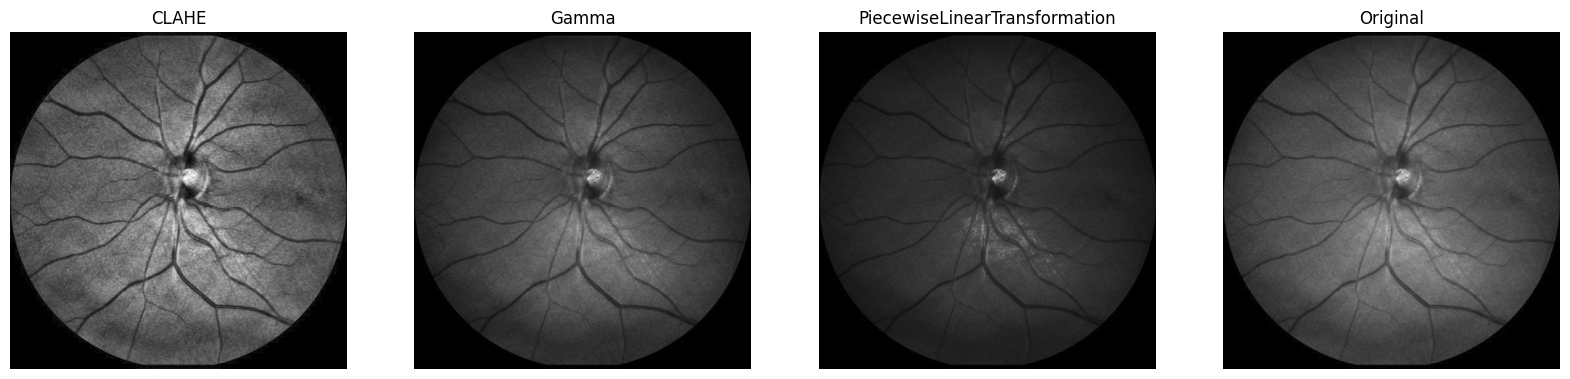

In [99]:
# Appliquer différents méthodes de contraste
contrast_methods = ['CLAHE', 'Gamma', 'PiecewiseLinearTransformation']
contrasted_images = {method: apply_contrast(img, method) for method in contrast_methods}

# Ajouter l'image originale pour comparaison
contrasted_images['Original'] = img

# Affichage des images
fig, axes = plt.subplots(1, len(contrasted_images), figsize=(20, 5))
for ax, (method, image) in zip(axes, contrasted_images.items()):
    if method != 'Original':  # Normaliser si ce n'est pas l'image originale
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    else:
        ax.imshow(image, cmap='gray')
    ax.set_title(method)
    ax.axis('off')

plt.show()

### c. Suppression de l'arrière-plan

In [101]:
def del_background(image, method):
    if method == 'black_tophat':
        return black_tophat(image, disk(4))
    elif method == 'white_tophat':
        return white_tophat(image, disk(4))
    else:
        raise ValueError(f"Unknown background subtraction method: {method}")

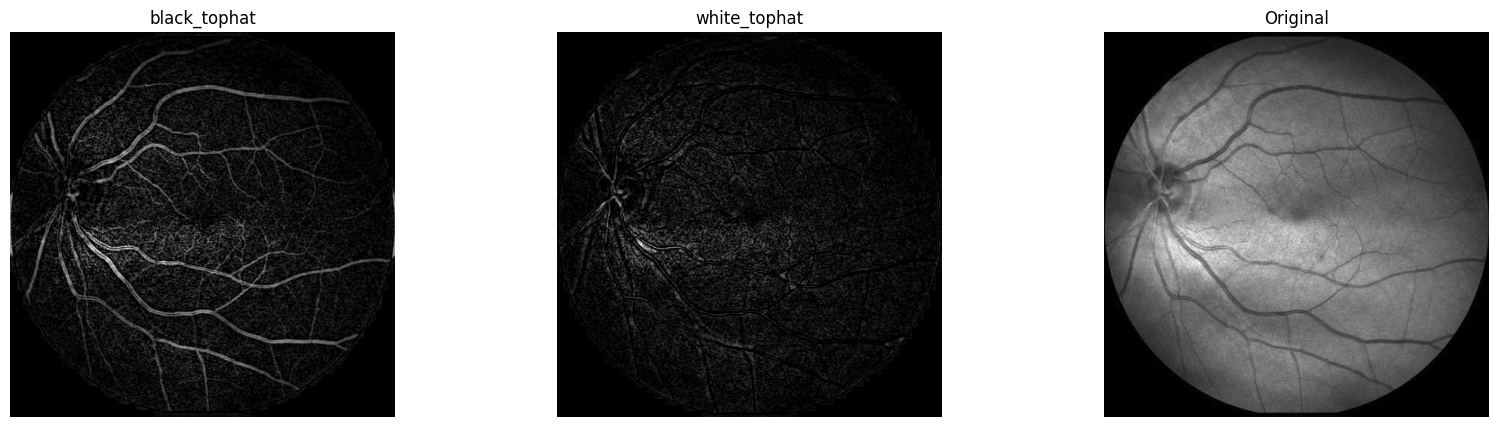

In [102]:
# Appliquer différentes méthodes de soustraction de l'arrière-plan
background_subtraction_methods = ['black_tophat', 'white_tophat']
background_subtracted_images = {method: del_background(img, method) for method in background_subtraction_methods}

# Ajouter l'image originale pour comparaison
background_subtracted_images['Original'] = img

# Affichage des images
fig, axes = plt.subplots(1, len(background_subtracted_images), figsize=(20, 5))
for ax, (method, image) in zip(axes, background_subtracted_images.items()):
    ax.imshow(image, cmap='gray')
    ax.set_title(method)
    ax.axis('off')

plt.show()

### d. Débruitage

In [103]:
def apply_denoising(image, method):
    if method == 'meijering':
        return meijering(image, range(1,5), black_ridges=False)
    else:
        raise ValueError(f"Unknown denoising method: {method}")

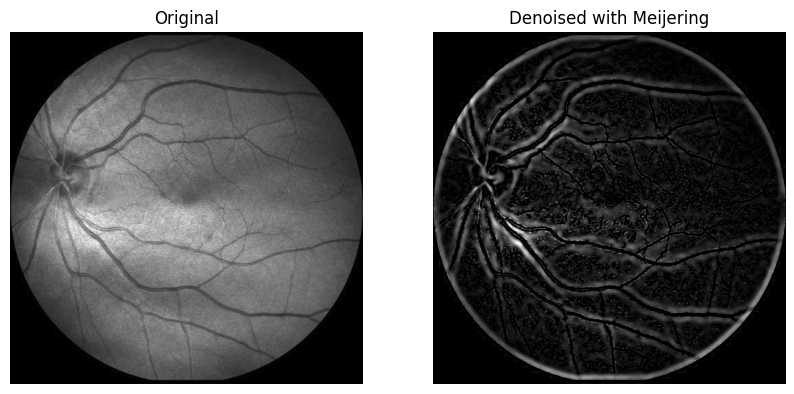

In [104]:
# Appliquer la méthode de débruitage Meijering
denoised_image = apply_denoising(img, 'meijering')

# Affichage des images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(denoised_image, cmap='gray')
axes[1].set_title('Denoised with Meijering')
axes[1].axis('off')

plt.show()

### e. Binarisation

In [105]:
def apply_binarization(image, method):
    if method == 'OTSU':
        thresh = threshold_otsu(image)
        binary = image > thresh
        return binary
    else:
        raise ValueError(f"Unknown binarization method: {method}")

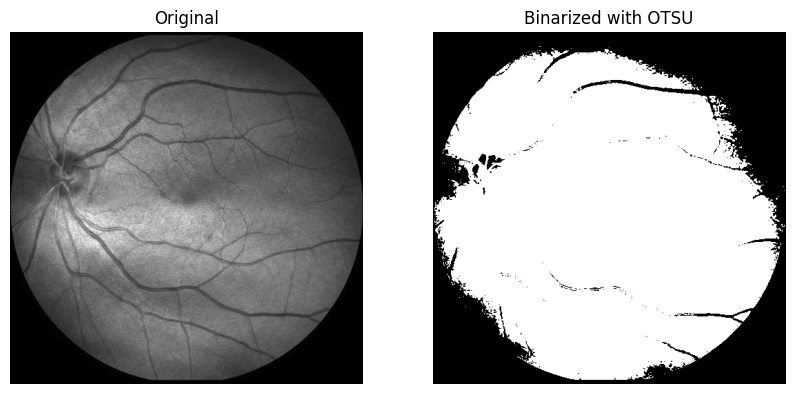

In [106]:
# Appliquer la binarisation d'Otsu
binarized_image = apply_binarization(img, 'OTSU')

# Affichage des images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(binarized_image, cmap='gray')
axes[1].set_title('Binarized with OTSU')
axes[1].axis('off')

plt.show()

## II. Segmentation

### Application d'un filtre linéaire et oonvolutions

In [112]:
def apply_linear_filters(image, l):
    # Définir les filtres linéaires
    linefilter1 = -1 * np.eye(l)
    linefilter1 = erosion(linefilter1, disk(1)) + 3 * np.eye(l)
    linefilter2 = linefilter1[::-1]
    
    linefilter3 = np.zeros((l, l))
    linefilter3[:, int((l - 1) / 2)] = 2
    linefilter3[:, int((l - 1) / 2) + 1], linefilter3[:, int((l - 1) / 2) - 1] = -1, -1
    
    linefilter4 = linefilter3.T

    # Appliquer les convolutions
    conv1 = ndi.convolve(image, linefilter1)
    conv2 = ndi.convolve(image, linefilter2)
    conv3 = ndi.convolve(image, linefilter3)
    conv4 = ndi.convolve(image, linefilter4)

    # Combinaison des images après convolution
    combine = conv1 + conv2 + conv3 + conv4

    return combine

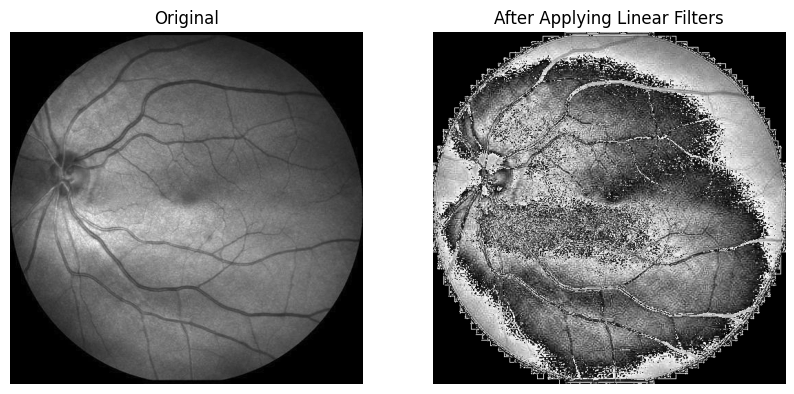

In [113]:
# Appliquer la fonction de filtres linéaires avec un paramètre l spécifique
filtered_image = apply_linear_filters(img, 5)  # Choisissez l en fonction de votre cas

# Affichage des images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(filtered_image, cmap='gray')
axes[1].set_title('After Applying Linear Filters')
axes[1].axis('off')

plt.show()

## III. Post-processing

### Application d'un masque et opérations morphologiques

In [125]:
def apply_mask(image):

    # Créer un masque
    #mask = np.zeros(image.shape, dtype="uint8")
    #cv2.rectangle(mask, (15, 15), (505, 505), 255, -1)  # Définir le rectangle

    # Appliquer le masque
    #masked_image = cv2.bitwise_and(image*255, image*255, mask=mask)

    #clos = closing(image, disk(1))
    # Suppression de quelques éléments isolés (non connexes à des vaisseaux)
    segmented = diameter_opening(image, diameter_threshold=11)

    return segmented

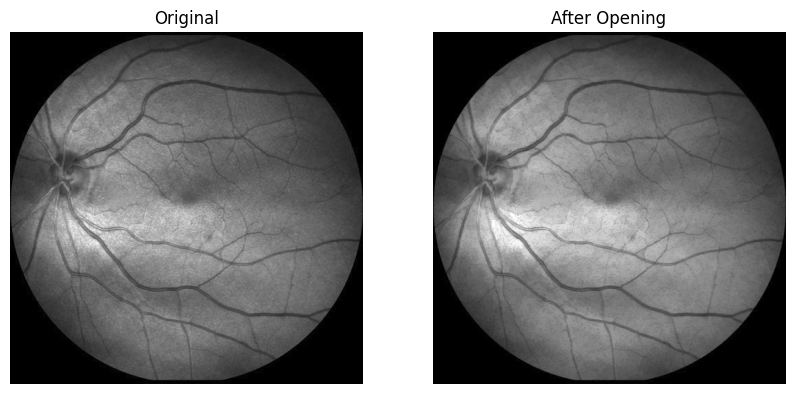

In [127]:
# Appliquer la fonction de masque sur l'image
masked_and_processed_image = apply_mask(img)

# Affichage des images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(masked_and_processed_image, cmap='gray')
axes[1].set_title('After Opening')
axes[1].axis('off')

plt.show()

# B. GridSearch

## GridSearch pour trouver les meilleurs approches pour chaques étapes de la segmentation

In [10]:
params_grid_method = [
    {'filter': ['median', 'hessian', 'laplace', 'frangi'],
     'contrast': ['CLAHE', 'Gamma', 'PiecewiseLinearTransformation'],
     'del_background': ['black_tophat', 'white_tophat'],
     'denoising': ['meijering'],
     'binary': ['OTSU']}
]

### a. GridSearch pour uniquement la première image

In [13]:
# la première image
img =  np.asarray(Image.open(image_paths[0])).astype(np.uint8)
img_GT =  np.asarray(Image.open(GT_paths[0])).astype(np.bool_)

In [14]:
def run_grid_search(img, ground_truth, params_grid):
    results = []
    
    for params in params_grid:
        # Crétion des toutes les combinaisons de paramètres
        combinations = list(itertools.product(*params.values()))
        param_keys = list(params.keys())
        for combination in combinations:
            param_dict = dict(zip(param_keys, combination))

            # Application des étapes de la segmentation
            processed_image = np.nan_to_num(apply_filter(img, param_dict['filter']))     # Application d'un filtre sur l'image originale pour retirer une partie du bruit initial
            processed_image = np.nan_to_num(apply_contrast(processed_image, param_dict['contrast']))     # Augmentation du contraste local de l'image
            processed_image = np.nan_to_num(del_background(processed_image, param_dict['del_background']))     # Suppression du background
            processed_image = np.nan_to_num(apply_denoising(processed_image, param_dict['denoising']))    # Débruitage du background
            segmented_image = np.nan_to_num(apply_binarization(processed_image, param_dict['binary']), nan=0.0)    # Seuillage d'Otsu pour binariser l'image
            combine = np.nan_to_num(apply_linear_filters(segmented_image, 3))    # Application des filtres linéaires pour détecter les vaisseaux sanguins
            segmented = np.nan_to_num(apply_mask(combine))    # Filtrage des artefacts : reste du contour de l'oeil, etc.

            # Evaluation des resultats
            ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel = evaluate(segmented, ground_truth)
            
            # Stockage des resultats
            results.append({
                "parameters": param_dict,
                "accuracy": ACCU,
                "recall": RECALL,
                "f1_score": F1_SCORE,
            })

    best_result = max(results, key=lambda x: x['f1_score'])
    print(f"Best result: {best_result}")

    return results, best_result

results_method_1, best_result_method_1 = run_grid_search(img, img_GT, params_grid_method)

/var/folders/cy/jxgrnlf57f78yz4v8gv0kn5h0000gn/T/ipykernel_23135/3970550371.py:6: RuntimeWarning: invalid value encountered in power
  retina_corrected_gamma = np.power(image, 1.2)
/var/folders/cy/jxgrnlf57f78yz4v8gv0kn5h0000gn/T/ipykernel_23135/3227550756.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ACCU = TP / (TP + FP) # Precision


Best result: {'parameters': {'filter': 'median', 'contrast': 'Gamma', 'del_background': 'black_tophat', 'denoising': 'meijering', 'binary': 'OTSU'}, 'accuracy': 0.7034428794992176, 'recall': 0.7189124350259896, 'f1_score': 0.7110935337156415}


In [15]:
print(best_result_method_1)

{'parameters': {'filter': 'median', 'contrast': 'Gamma', 'del_background': 'black_tophat', 'denoising': 'meijering', 'binary': 'OTSU'}, 'accuracy': 0.7034428794992176, 'recall': 0.7189124350259896, 'f1_score': 0.7110935337156415}


### b. GridSearch pour toutes les images

In [16]:
# Chemins vers les images d'origines
image_paths = ['images_IOSTAR/star01_OSC.jpg',
'images_IOSTAR/star02_OSC.jpg',
'images_IOSTAR/star03_OSN.jpg',
'images_IOSTAR/star08_OSN.jpg',
'images_IOSTAR/star21_OSC.jpg',
'images_IOSTAR/star26_ODC.jpg',
'images_IOSTAR/star28_ODN.jpg',
'images_IOSTAR/star32_ODC.jpg',
'images_IOSTAR/star37_ODN.jpg',
'images_IOSTAR/star48_OSN.jpg']

# Chemins vers les images vérité terrains
GT_paths = [
'images_IOSTAR/GT_01.png',
'images_IOSTAR/GT_02.png',
'images_IOSTAR/GT_03.png',
'images_IOSTAR/GT_08.png',
'images_IOSTAR/GT_21.png',
'images_IOSTAR/GT_26.png',
'images_IOSTAR/GT_28.png',
'images_IOSTAR/GT_32.png',
'images_IOSTAR/GT_37.png',
'images_IOSTAR/GT_48.png']

In [17]:
def run_grid_search_on_multiple_images(image_paths, GT_paths, params_grid):
    f1_scores = {}
    images = [io.imread(img_path) for img_path in image_paths]
    GTs = [io.imread(gt_path) for gt_path in GT_paths]

    for img_path, gt_path in zip(image_paths, GT_paths):
        print(f"Testing images: {img_path}")
        img = np.asarray(Image.open(img_path)).astype(np.uint8)
        img_gt = np.asarray(Image.open(gt_path)).astype(np.bool_)

        
        params = params_grid[0]
        combinations = list(itertools.product(*(params[key] for key in params)))
        
        for combination in combinations:
            param_dict = dict(zip(params.keys(), combination))
            
            # Logique de traitement et d'évaluation...
            processed_image = np.nan_to_num(apply_filter(img, param_dict['filter']))
            processed_image = np.nan_to_num(apply_contrast(processed_image, param_dict['contrast']))
            processed_image = np.nan_to_num(del_background(processed_image, param_dict['del_background']))
            processed_image = np.nan_to_num(apply_denoising(processed_image, param_dict['denoising']))
            segmented_image = np.nan_to_num(apply_binarization(processed_image, param_dict['binary']), nan=0.0)
            combine = np.nan_to_num(apply_linear_filters(segmented_image, 3))
            segmented = np.nan_to_num(apply_mask(combine))
            
            # Évaluation...
            ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel = evaluate(segmented, img_gt)
            f1_score = F1_SCORE
            
            # Stockage du F1-score
            param_key = str(param_dict)
            if param_key not in f1_scores:
                f1_scores[param_key] = []
            f1_scores[param_key].append(f1_score)

    # Calcul du F1-score moyen pour chaque ensemble de paramètres
    f1_scores_mean = {param: np.mean(scores) for param, scores in f1_scores.items()}

    # Sélection de l'ensemble de paramètres avec le meilleur F1-score moyen
    best_params = max(f1_scores_mean, key=f1_scores_mean.get)
    best_score = f1_scores_mean[best_params]

    return best_params, best_score, f1_scores_mean

best_params_method, best_score_method, f1_scores_mean_method = run_grid_search_on_multiple_images(image_paths,GT_paths, params_grid_method)


Testing images: images_IOSTAR/star01_OSC.jpg


/var/folders/cy/jxgrnlf57f78yz4v8gv0kn5h0000gn/T/ipykernel_23135/3970550371.py:6: RuntimeWarning: invalid value encountered in power
  retina_corrected_gamma = np.power(image, 1.2)
/var/folders/cy/jxgrnlf57f78yz4v8gv0kn5h0000gn/T/ipykernel_23135/3227550756.py:8: RuntimeWarning: invalid value encountered in scalar divide
  ACCU = TP / (TP + FP) # Precision


Testing images: images_IOSTAR/star02_OSC.jpg
Testing images: images_IOSTAR/star03_OSN.jpg
Testing images: images_IOSTAR/star08_OSN.jpg
Testing images: images_IOSTAR/star21_OSC.jpg
Testing images: images_IOSTAR/star26_ODC.jpg
Testing images: images_IOSTAR/star28_ODN.jpg
Testing images: images_IOSTAR/star32_ODC.jpg
Testing images: images_IOSTAR/star37_ODN.jpg
Testing images: images_IOSTAR/star48_OSN.jpg


In [18]:
print(f"Meilleur ensemble d'approches : {best_params_method} avec un score F1 moyen de {best_score_method}")

Meilleur ensemble d'approches : {'filter': 'median', 'contrast': 'CLAHE', 'del_background': 'black_tophat', 'denoising': 'meijering', 'binary': 'OTSU'} avec un score F1 moyen de 0.7171202270447482


### c. Fonction de segmentation
##### Création de la fonction de segmentation avec les méthodes trouvés à l'aide du GridSearch précendent :

In [53]:
from skimage import morphology, measure

def my_segmentation(img_src, l=3, kernel_size=32, disk_size=4, diameter_threshold=9):
    med = median(img_src)
    hat = black_tophat(med, disk(disk_size))
    rescale = exposure.equalize_adapthist(hat, kernel_size=kernel_size, clip_limit = 0.042) #Algorithme CLAHE
    meij = meijering(rescale, range(1,5), black_ridges=False)
    thresh = threshold_otsu(meij)
    otsu = meij > thresh

    cleaned_img = morphology.remove_small_objects(otsu, min_size=100)
    
    # Remplir les petits trous
    filled_img = morphology.remove_small_holes(cleaned_img, area_threshold=20)

    linefilter1 = -1 * np.eye(l)
    linefilter1 = erosion(linefilter1, disk(1)) + 3 * np.eye(l)
    linefilter2 = linefilter1[::-1]
    linefilter3 = np.zeros((l,l))
    linefilter3[:,int((l-1)/2)] = 2
    linefilter3[:,int((l-1)/2)+1], linefilter3[:,int((l-1)/2)-1] = -1, -1
    linefilter4 = linefilter3.T
    conv1 = ndi.convolve(filled_img, linefilter1)
    conv2 = ndi.convolve(filled_img, linefilter2)
    conv3 = ndi.convolve(filled_img, linefilter3)
    conv4 = ndi.convolve(filled_img, linefilter4)
    combine = conv1 + conv2 + conv3 + conv4 # Convolution
    mask = np.zeros(combine.shape, dtype="uint8")
    cv2.rectangle(mask, (15, 15), (505, 505), 255, -1)
    thins = cv2.bitwise_and(combine*255, combine*255, mask=mask)
    clos = closing(thins, disk(1))
    segmented = diameter_opening(clos, diameter_threshold=diameter_threshold)
    
    return segmented

## GridSearch pour trouver les meilleurs hyperparamètres pour chaques méthodes

In [70]:
params_grid_p = {
    'l': [2, 3, 4, 5, 6],
    'kernel_size': [32, 40, 48],
    'disk_size': [3, 4, 5, 6],
    'diameter_threshold': [8, 9, 10, 11]
}

### a. GridSearch pour uniquement la première image

In [55]:
# la première image
img =  np.asarray(Image.open(image_paths[0])).astype(np.uint8)
img_GT =  np.asarray(Image.open(GT_paths[0])).astype(np.bool_)

In [ ]:
def grid_search_segmentation(img_src, GT_src, params_grid, n_iter = 10, results_file= 'resultats/grid_search_p_1_results.json'):

    all_params_combinations = list(ParameterSampler(params_grid, n_iter=n_iter, random_state=0)) # Création d'un générateur de combinaisons aléatoires afin d'éviter de toutes les tester
    results = []
    best_accuracy = 0
    best_recall = 0
    best_f1_score = 0
    best_params = {}

    for params in all_params_combinations:
        segmented = my_segmentation(img_src, **params)
        ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel = evaluate(segmented, img_GT)
        if F1_SCORE > best_f1_score:
            best_accuracy = ACCU
            best_f1_score = F1_SCORE
            best_recall = RECALL
            best_params = params

        result = {
            'params': params,
            'accuracy': ACCU,
            'recall': RECALL,
            'f1_score': F1_SCORE
        }
        results.append(result)

        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)

    return best_params, best_accuracy, best_recall, best_f1_score

best_params_p_1, best_accuracy_p_1, best_recall_p_1, best_f1_score_p_1 = grid_search_segmentation(img, img_GT, params_grid_p, n_iter = 50)
print(f"Meilleur ensemble de paramètres: {best_params_p_1} \n avec un score F1 moyen de {best_f1_score_p_1},\n une accuracy de {best_accuracy_p_1}\n et un recall de {best_recall_p_1}")

### b. GridSearch pour toutes les images

In [71]:
# Chemins vers les images d'origines
image_paths = ['images_IOSTAR/star01_OSC.jpg',
'images_IOSTAR/star02_OSC.jpg',
'images_IOSTAR/star03_OSN.jpg',
'images_IOSTAR/star08_OSN.jpg',
'images_IOSTAR/star21_OSC.jpg',
'images_IOSTAR/star26_ODC.jpg',
'images_IOSTAR/star28_ODN.jpg',
'images_IOSTAR/star32_ODC.jpg',
'images_IOSTAR/star37_ODN.jpg',
'images_IOSTAR/star48_OSN.jpg']

# Chemins vers les images vérité terrains
GT_paths = [
'images_IOSTAR/GT_01.png',
'images_IOSTAR/GT_02.png',
'images_IOSTAR/GT_03.png',
'images_IOSTAR/GT_08.png',
'images_IOSTAR/GT_21.png',
'images_IOSTAR/GT_26.png',
'images_IOSTAR/GT_28.png',
'images_IOSTAR/GT_32.png',
'images_IOSTAR/GT_37.png',
'images_IOSTAR/GT_48.png']

In [72]:
def grid_search_segmentation_multiple_images(image_paths, GT_paths, params_grid, n_iter=10, results_file='resultats/grid_search_p_results.json'):
    results = []
    best_average_f1_score = 0
    
    images = [io.imread(img_path) for img_path in image_paths]
    GTs = [io.imread(gt_path) for gt_path in GT_paths]

    all_params_combinations = list(ParameterSampler(params_grid, n_iter=n_iter, random_state=0))
    
    for params in all_params_combinations:
        f1_scores = []
        for img, img_GT in zip(images, GTs):
            # Assurez-vous que l'image et img_GT sont correctement prétraitées si nécessaire
            segmented = my_segmentation(img, **params)
            ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel = evaluate(segmented, img_GT)
            f1_scores.append(F1_SCORE)
        
        average_f1_score = np.mean(f1_scores)

        result = {
            'params': params,
            'average_f1_score': average_f1_score
        }
        results.append(result)

        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)
        
    best_result = max(results, key=lambda x: x['average_f1_score'])
    
    return best_result

In [73]:
best_result_p = grid_search_segmentation_multiple_images(image_paths, GT_paths, params_grid_p, n_iter=240)

print(f"Meilleur ensemble de paramètres: {best_result_p['params']}")
print(f"Meilleur score F1 moyen: {best_result_p['average_f1_score']}")

Meilleur ensemble de paramètres: {'l': 3, 'kernel_size': 32, 'disk_size': 3, 'diameter_threshold': 8}
Meilleur score F1 moyen: 0.7647182616466166


# C. Résultats

In [89]:
# Chemins vers les images d'origines
image_paths = ['images_IOSTAR/star01_OSC.jpg',
'images_IOSTAR/star02_OSC.jpg',
'images_IOSTAR/star03_OSN.jpg',
'images_IOSTAR/star08_OSN.jpg',
'images_IOSTAR/star21_OSC.jpg',
'images_IOSTAR/star26_ODC.jpg',
'images_IOSTAR/star28_ODN.jpg',
'images_IOSTAR/star32_ODC.jpg',
'images_IOSTAR/star37_ODN.jpg',
'images_IOSTAR/star48_OSN.jpg']

# Chemins vers les images vérité terrains
GT_paths = [
'images_IOSTAR/GT_01.png',
'images_IOSTAR/GT_02.png',
'images_IOSTAR/GT_03.png',
'images_IOSTAR/GT_08.png',
'images_IOSTAR/GT_21.png',
'images_IOSTAR/GT_26.png',
'images_IOSTAR/GT_28.png',
'images_IOSTAR/GT_32.png',
'images_IOSTAR/GT_37.png',
'images_IOSTAR/GT_48.png']

In [90]:
def evaluate_individual_images(image, GT, best_params):
    evaluations = []

    for img_path, gt_path in zip(image, GT):
        print(f"Évaluation de l'image: {img_path}")
        img = np.asarray(Image.open(img_path)).astype(np.uint8) 
        img_gt = np.asarray(Image.open(gt_path)).astype(np.bool_)

        segmented = my_segmentation(img, **best_params)
        ACCU, RECALL, F1_SCORE, img_out_skel, GT_skel = evaluate(segmented, img_gt)
        
        evaluations.append({
            "image_path": img_path,
            "accuracy": ACCU,
            "recall": RECALL,
            "f1_score": F1_SCORE
        })
    
    return evaluations


In [91]:
evaluations = evaluate_individual_images(image_paths, GT_paths, best_result_p['params'])

Évaluation de l'image: images_IOSTAR/star01_OSC.jpg
Évaluation de l'image: images_IOSTAR/star02_OSC.jpg
Évaluation de l'image: images_IOSTAR/star03_OSN.jpg
Évaluation de l'image: images_IOSTAR/star08_OSN.jpg
Évaluation de l'image: images_IOSTAR/star21_OSC.jpg
Évaluation de l'image: images_IOSTAR/star26_ODC.jpg
Évaluation de l'image: images_IOSTAR/star28_ODN.jpg
Évaluation de l'image: images_IOSTAR/star32_ODC.jpg
Évaluation de l'image: images_IOSTAR/star37_ODN.jpg
Évaluation de l'image: images_IOSTAR/star48_OSN.jpg


In [92]:
# Créer d'un dossier qui contiendra les images
images_folder = 'images'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

In [128]:
html_str = '<table><tr><th>Original Image</th><th>Ground Truth</th><th>Segmented Image</th><th>Accuracy</th><th>Recall</th><th>F1-Score</th></tr>'

# Initialisation des sommes pour chaque métrique
sum_accuracy = 0
sum_recall = 0
sum_f1_score = 0

# Nombre d'évaluations
n_evaluations = len(evaluations)

for i, eval in enumerate(evaluations, start=1):
    img = io.imread(eval['image_path'])
    gt_path = GT_paths[i-1]  # Assurez-vous que GT_paths contient les chemins vers les images de vérité terrain dans le même ordre que evaluations
    gt_img = io.imread(gt_path)
    segmented = my_segmentation(img, **best_result_p['params'])

    # Chemins pour enregistrer les images
    original_img_path = os.path.join(images_folder, f'original_{i}.png')
    gt_img_path = os.path.join(images_folder, f'gt_{i}.png')
    segmented_img_path = os.path.join(images_folder, f'segmented_{i}.png')

    # Enregistrer les images
    plt.imsave(original_img_path, img, cmap='gray')
    plt.imsave(gt_img_path, gt_img, cmap='gray')
    plt.imsave(segmented_img_path, segmented, cmap='gray')

    # Ajouter une ligne au tableau HTML pour chaque image
    html_str += f'<tr>'
    html_str += f'<td><img src="{original_img_path}" width="100"></td>'
    html_str += f'<td><img src="{gt_img_path}" width="100"></td>'
    html_str += f'<td><img src="{segmented_img_path}" width="100"></td>'
    html_str += f'<td>{eval["accuracy"]:.3f}</td><td>{eval["recall"]:.3f}</td><td>{eval["f1_score"]:.3f}</td></tr>'

    sum_accuracy += eval["accuracy"]
    sum_recall += eval["recall"]
    sum_f1_score += eval["f1_score"]

# Calculer les moyennes pour chaque métrique
mean_accuracy = sum_accuracy / n_evaluations
mean_recall = sum_recall / n_evaluations
mean_f1_score = sum_f1_score / n_evaluations

# Ajouter une ligne au tableau HTML pour les moyennes
html_str += f'<tr><td colspan="3"><strong>Moyennes</strong></td>'
html_str += f'<td><strong>{mean_accuracy:.3f}</strong></td>'
html_str += f'<td><strong>{mean_recall:.3f}</strong></td>'
html_str += f'<td><strong>{mean_f1_score:.3f}</strong></td></tr>'

html_str += '</table>'

# Afficher le tableau HTML
from IPython.core.display import HTML
display(HTML(html_str))


Original Image,Ground Truth,Segmented Image,Accuracy,Recall,F1-Score
,,,0.797,0.785,0.791
,,,0.670,0.856,0.751
,,,0.898,0.683,0.776
,,,0.961,0.648,0.774
,,,0.724,0.677,0.700
,,,0.770,0.727,0.748
,,,0.783,0.687,0.732
,,,0.766,0.748,0.757
,,,0.811,0.782,0.796
,,,0.893,0.761,0.822
